1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


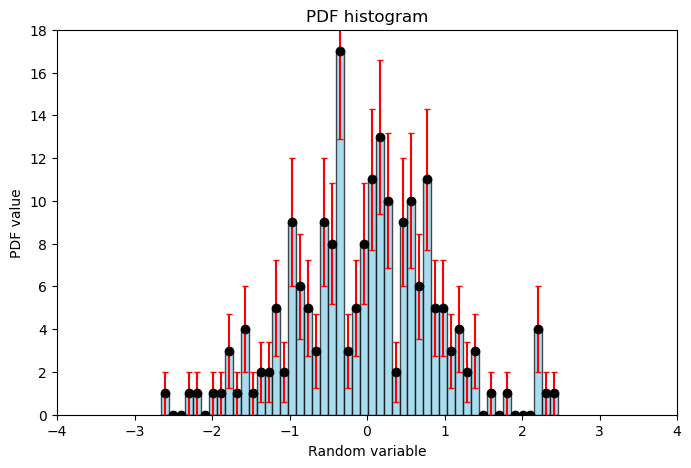

TypeError: _parse_args() takes from 1 to 3 positional arguments but 4 were given

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from scipy import stats 

x = np.array(np.random.normal(0, 1, 200))
#print(x)

nbins = 50

counts, bin_edges = np.histogram(x, nbins) #It saves the bin edges, and the counts of data for each bin.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 #This shifts the two arrays, making the calculation much more rapid. 
errors = np.sqrt(counts)

 
plt.figure(figsize=(8, 5))
plt.hist(x, bins=nbins, color='skyblue', edgecolor='black', alpha=0.7)
plt.errorbar(
    x=bin_centers, 
    y=counts, 
    yerr=errors, 
    fmt='o',          # 'o' means plot as dots (data points)
    color='black',    # Color of the dots and bars
    ecolor='red',     # Optional: make the error bars a different color
    capsize=2,        # Adds the little horizontal lines at the tips
    label='Data $\pm\sqrt{N}$'
)

plt.title("PDF histogram")
plt.xlabel("Random variable")
plt.ylabel("PDF value")
plt.xticks(np.arange(-5, 5, 1))
plt.yticks(np.arange(0, 20, 2))
plt.xlim(-4,4)
plt.ylim(0, 18)

plt.show()


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-17 14:38:20--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2020-11-17 14:38:20--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucf08e6905d1af2d3896db082fc4.dl.dropboxusercontent.com/cd/0/inline/BDXix2_dqdgaay0CqpUasoeq-d7qojUHdcsmMO4LSt4qx-6aIfFdyTse5ykuTp1AKTZzWHqB83UcrULRU6e9PqpgyW2Ud6gq_BVV1oIDp8Jfng/file# [segue]
--2020-11-17 14:38:21--  https://ucf08e6905d1af2d3896db082fc4.dl.dropboxusercontent.com/cd/0/inline/BDXix2_dqdgaay0CqpUasoeq-d7qojUHdcsmMO4LSt4qx-6aIfFdyTse5ykuTp1AKTZzWHqB83Ucr

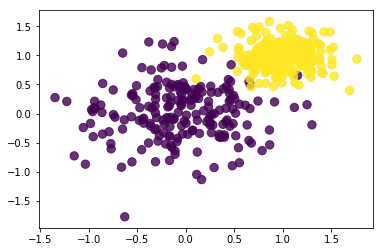

In [18]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot